In [0]:
import torch as T
print("PyTorch:\t{}".format(torch.__version__))
import torch.nn as nn
import numpy as np
import io
import glob
import torch.nn.functional as F
import torch.optim as optim
import gym
from itertools import count
import matplotlib.pyplot as plt
import math
import base64
import random
from gym import wrappers

PyTorch:	1.4.0


In [0]:
class network(nn.Module):
    def __init__(self, alpha, inp, for1, for2, actions):
        #Initializing neural networks
        super(network, self).__init__()
        self.for1 = for1
        self.inp = inp
        #Three Layer Network
        self.f1 = nn.Linear(*self.inp, self.for1)
        self.for2 = for2
        self.f2 = nn.Linear(self.for1, self.for2)
        self.actions = actions
        self.f3 = nn.Linear(self.for2, actions)
        #Optimizer
        self.optimizer = optim.Adam(self.parameters(), lr=alpha)
        #Using CUDA for accelerated training
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cuda:1')
        self.to(self.device)

    '''I have coded only one network above which can used by both the actor 
       and critic and the with actor giving out probabilities and the critic 
       tells the actor which action to take'''
    def forward(self, observation):
        #Forward state
        state = T.Tensor(observation).to(self.device)
        x = F.relu(self.f1(state))
        x = F.relu(self.f2(x))
        x = self.f3(x)
        return x

In [0]:
class ACAg(object):
    def __init__(self, a, b, inp, n_actions=2, gam=0.99,layer1=16, layer2=16):
        #Initialising values
        self.lay1=layer1
        self.lay2=layer2
        self.actions=n_actions
        #Actor Network
        self.actor=network(a,inp,self.lay1,self.lay2,self.actions)
        #Critic Network
        self.critic=network(b,inp,self.lay1,self.lay2,actions=1)
        self.log_probs=None
        self.gamma=gam

    #To update the weights of network
    def update(self, state, reward, new_state, done):
        #Function to implement actor critic
        self.critic.optimizer.zero_grad()
        self.actor.optimizer.zero_grad()
        #To find critic value
        critic_value = self.critic.forward(state)
        critic_value_a = self.critic.forward(new_state)
        reward = T.tensor(reward, dtype=T.float).to(self.actor.device)
        fut_rew = reward + self.gamma*critic_value_a*(1-int(done)) - critic_value
        c_loss = fut_rew**2
        #print(fut_rew)
        #Update Loss
        a_loss = -self.log_probs * fut_rew
        #actor_loss.backward(retain_graph=True)
        #critic_loss.backward()
        (a_loss + c_loss).backward()
        self.critic.optimizer.step()
        self.actor.optimizer.step()
    
    #Choosing the Action
    def action_choose(self, observation):
        #To choose new actions according to policy
        pros = F.softmax(self.actor.forward(observation))
        ap = T.distributions.Categorical(pros)
        action = ap.sample()
        self.lp = ap.lp(action)
        return action.item()

Episode: 1, Rewards: 31.0, Average/Running Rewards: 31.0
Episode: 2, Rewards: 15.0, Average/Running Rewards: 23.0
Episode: 3, Rewards: 42.0, Average/Running Rewards: 29.333333333333332
Episode: 4, Rewards: 10.0, Average/Running Rewards: 24.5
Episode: 5, Rewards: 16.0, Average/Running Rewards: 22.8
Episode: 6, Rewards: 11.0, Average/Running Rewards: 20.833333333333332
Episode: 7, Rewards: 15.0, Average/Running Rewards: 20.0
Episode: 8, Rewards: 16.0, Average/Running Rewards: 19.5
Episode: 9, Rewards: 21.0, Average/Running Rewards: 19.666666666666668
Episode: 10, Rewards: 13.0, Average/Running Rewards: 19.0
Episode: 11, Rewards: 14.0, Average/Running Rewards: 18.545454545454547
Episode: 12, Rewards: 17.0, Average/Running Rewards: 18.416666666666668
Episode: 13, Rewards: 23.0, Average/Running Rewards: 18.76923076923077
Episode: 14, Rewards: 14.0, Average/Running Rewards: 18.428571428571427
Episode: 15, Rewards: 18.0, Average/Running Rewards: 18.4
Episode: 16, Rewards: 29.0, Average/Runnin

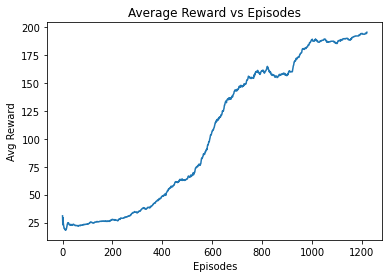

In [0]:
gam=0.99
acti=2
agent = ACAg(a=0.0001, b=0.0001, inp=[4], acti, gam, layer1=64, layer2=64)
env = gym.make('CartPole-v0')
avg_rewards=0
flag=0
avv=[]
score = 0
de=1
hist = []
asc=0
num_ep = 1500
for i in count(1):
    obs = env.reset()
    score = 0
    done = False
    while(not done):
        #To choose action and pass to find the next state
        action=agent.action_choose(obs)
        new_obs, rew, done, info = env.step(action)
        de+=1
        agent.update(obs, rew, new_obs, done)
        obs=new_obs
        score+=rew
    hist.append(score)
    avg_rewards = np.mean(hist[-50:])
    #Printing episode and rewards
    print("Episode: {}, Rewards: {}, Average/Running Rewards: {}".format(i, score,  avg_rewards))
    avv.append(avg_rewards)
    asc+=1
    if(avg_rewards > env.spec.reward_threshold):
        print("Solved! Running/Average reward is {}".format(avg_rewards))
        flag=1
        break
    if(flag==1):
        break

#Plot graph
plt.figure(1)             
plt.plot(avv)
plt.title('Average Reward vs Episodes')
plt.ylabel('Avg Reward')
plt.xlabel('Episodes') 